# Kaggle Titanic Competition
###Karen Xiao

5/6/2015

Python implementation of the Kaggle Titanic Competition: http://www.kaggle.com/c/titanic

##Loading in Data
First, we will read in the data file `titanic.csv` and store it as a Numpy array. We will be using the `csv` package to read and write csv files and the `Numpy` package for some of its array and other functions.

In [2]:
import csv as csv 
import numpy as np

raw_csv = csv.reader(open('titanic_full.csv', 'rb')) 

# skip the header
header = raw_csv.next()

# read in rows from the raw_csv file and store in data variable         
data=[]                        
for row in raw_csv:     
    data.append(row)       
data = np.array(data) 

print header
print data[0]

['survived', 'name', 'sex', 'age', 'sibsp', 'parch', 'pclass', 'ticket', 'fare', 'cabin', 'embarked', 'boat', 'body', 'home.dest']
['1' 'Allen, Miss. Elisabeth Walton' 'female' '29' '0' '0' '1' '24160'
 '211.3375' 'B5' 'S' '2' '' 'St Louis, MO']


##Plotting the Data
Now that we have the data loaded in, we can plot some initial data just to get a sense of what we have. Here we will use a plotting library called `Matplotlib`. As a first hypothesis, we might look at the survival chances based on gender. 

Percentage of women who survived: 0.727467811159
Percentage of men who survived: 0.190984578885


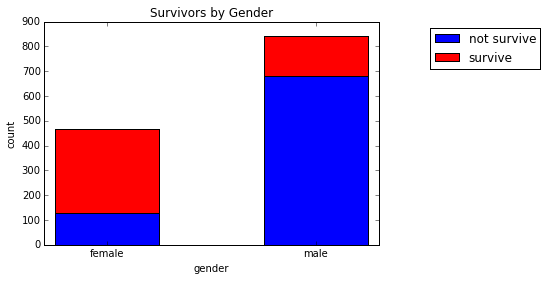

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

# define "mask" variables that can be applied on the data to filter on females in column 4
female_mask = data[0::,2] == "female"
male_mask = data[0::,2] != "female"

women = data[female_mask,0].astype(np.float)     
men = data[male_mask,0].astype(np.float)

# calculate percentages
print "Percentage of women who survived: %s" % (np.sum(women) / np.size(women))
print "Percentage of men who survived: %s" % (np.sum(men) / np.size(men))

# plot the data
width = .5
index = np.arange(2) + .25
survived = [np.sum(women), np.sum(men)]
died = [np.size(women) - np.sum(women), np.size(men) - np.sum(men)] 

plot_died = plt.bar(index, died, width, color='b')
plot_survived = plt.bar(index, survived, width, color='r', bottom=died)   

plt.title('Survivors by Gender')
plt.ylabel('count')
plt.xlabel('gender')
plt.xticks(index+.25, ['female', 'male'])
plt.legend((plot_died, plot_survived), ('not survive', 'survive'), bbox_to_anchor=(1.5, 1))

plt.show()

##A Simple Gender-based Model
Now that we've looked at this dimension of the data, we can create a very basic model to predict whether a passenger will survive purely based off of their gender. Clearly, this model is not going to give us the best results, but it works as an initial exercise.

The code below will read in the data, apply our model, and output our prediction to a csv file in a format ready for submission to Kaggle. Unlike before, instead of using a Numpy array to store and manipulate our data, we will be using a Pandas DataFrame, which has some more sophisticated capabilities. 

In [4]:
import pandas as pd
from sklearn.metrics import confusion_matrix

# read in the data file and store as a DataFrame
df = pd.read_csv('titanic_full.csv')

# create prediction DataFrame with 'survived' set to 1 if the passenger is female
predictions = df['sex'].map({'female': 1, 'male': 0})

# evaluate our results with a confusion matrix
confusion_matrix(df.survived.values, predictions, labels=[0,1])

array([[682, 127],
       [161, 339]])

Based off our confusion matrix, we see that this model predicted death 682 times correctly and 127 incorrectly. And predicted survival 339 times correctly and 161 times incorrectly. This means our model is about 78% accurate. However, let's see if we can do better. 

##Cleaning the Data
At this point, we probably want to do something a little more complex and use more than just one paramter to make our predictions. However, taking a closer look at our data reveals a few gaps. Notice when we run the `df.info()` command, we find that `age, fare, cabin, embarked, boat, body` and `home.dest` are missing some values:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 1308
Data columns (total 14 columns):
survived     1309 non-null int64
name         1309 non-null object
sex          1309 non-null object
age          1046 non-null float64
sibsp        1309 non-null int64
parch        1309 non-null int64
pclass       1309 non-null int64
ticket       1309 non-null object
fare         1308 non-null float64
cabin        295 non-null object
embarked     1307 non-null object
boat         486 non-null object
body         121 non-null float64
home.dest    745 non-null object
dtypes: float64(3), int64(4), object(7)
memory usage: 153.4+ KB


The decision now is what to fill the missing data with. We obviously don't want to just guess or fill it with random values because that will introduce a lot of noise into our data. Common options are to fill the data with the mean or median values for that column. 

In [6]:
"""
Function
--------
clean_missing_data

Given a DataFrame, fill in the missing Age and Fare data with median values

Inputs
------
df : DataFrame
    The DataFrame object read in from the Kaggle Titanic train and test csv files
"""    

def clean_missing_data(df):

    # ceate new column converting sex (female, male) stored as strings to gender (0, 1) stored as ints
    df['gender'] = df.sex.map({'female': 0, 'male': 1}).astype(int)

    # create our reference table for median ages based on passenger class and gender
    median_ages = np.zeros((2, 3))
    for i in range(2):
        for j in range(3):
            median_ages[i, j] = df[(df.gender == i) & (df.pclass == j+1)]['age'].dropna().median()

    # fill in missing age values
    for index, row in df[df['age'].isnull()].iterrows():
        df.loc[index,'age'] = median_ages[row.gender][row.pclass-1]

    # make embarked a useable column 
    embarked_new = pd.get_dummies(df.embarked, prefix="embarked")
    for i in range(len(embarked_new.columns)):
        df.insert(len(df.columns), embarked_new.columns.values[i], embarked_new[embarked_new.columns.values[i]])
    
    return df

# fill in the missing data 
df1 = clean_missing_data(df)
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 1308
Data columns (total 18 columns):
survived      1309 non-null int64
name          1309 non-null object
sex           1309 non-null object
age           1309 non-null float64
sibsp         1309 non-null int64
parch         1309 non-null int64
pclass        1309 non-null int64
ticket        1309 non-null object
fare          1308 non-null float64
cabin         295 non-null object
embarked      1307 non-null object
boat          486 non-null object
body          121 non-null float64
home.dest     745 non-null object
gender        1309 non-null int64
embarked_C    1309 non-null float64
embarked_Q    1309 non-null float64
embarked_S    1309 non-null float64
dtypes: float64(6), int64(5), object(7)
memory usage: 194.3+ KB


For the purposes of this exercise, and to more easily use the scikit-learn package, we don't want any non-numeric values. So using the `df.dtypes`, we find that the `name, sex, ticket, cabin, embarked, boat, home.dest` columns are of type object (which means string in Pandas). For now, since we don't need them, we will remove these columns. For the purposes of our next exercise, we will also remove `body`.

In [7]:
# drop unneeded (non-numerical) columns
clean_df = df1.drop(['name', 'sex', 'ticket', 'cabin', 'embarked', 'boat', 'home.dest', 'body', 'fare'], axis=1)
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 1308
Data columns (total 9 columns):
survived      1309 non-null int64
age           1309 non-null float64
sibsp         1309 non-null int64
parch         1309 non-null int64
pclass        1309 non-null int64
gender        1309 non-null int64
embarked_C    1309 non-null float64
embarked_Q    1309 non-null float64
embarked_S    1309 non-null float64
dtypes: float64(4), int64(5)
memory usage: 102.3 KB


Now we have a nice and clean dataset! The last step is to split it into the train and test sets.

In [8]:
from sklearn.cross_validation import train_test_split

# split into test and train sets
train_data, test_data = train_test_split(clean_df.values, test_size=0.3, random_state=42)

# keep around the feature names
features = clean_df.drop(['survived'], axis=1).columns.values

Now that we have a clean data set that's in a consummable Numpy array format, we can start running it against some models.

##Logistic Regression
Logistic regression usually works well for binary classifications. In this case, we are predicting if a passenger survived or didn't survive, so logistic regression is probably a good one to start with.

In [21]:
from sklearn.linear_model import LogisticRegression 
from sklearn.feature_selection import chi2

# create the logistic regression object which will include all the parameters for the fit
reg_clf = LogisticRegression()

# fit the training data to the survived labels 
reg_clf = reg_clf.fit(train_data[0::,1::],train_data[0::,0])

# print coefficiencts of logistic regression
coef = np.absolute(reg_clf.coef_[0])
indices = np.argsort(coef)[::-1]
print("Coefficients:")
for f in range(len(indices)):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], features[indices[f]], coef[indices[f]]))

# run on the test data
predictions = reg_clf.predict(test_data[0::,1::])

# score the predictions
score = reg_clf.score(test_data[0::,1::], test_data[0::,0])
print "Score: %s" % score

# print the confusion matrix
print "Confusion Matrix:"
cm = confusion_matrix(test_data[0::,0], predictions)
print cm
print "Normalized Confusion Matrix:"
normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print normalized


Coefficients:
1. feature 4 gender (2.370282)
2. feature 5 embarked_C (1.200516)
3. feature 3 pclass (0.829040)
4. feature 7 embarked_S (0.583445)
5. feature 6 embarked_Q (0.484600)
6. feature 1 sibsp (0.200413)
7. feature 2 parch (0.030449)
8. feature 0 age (0.017602)
Score: 0.801526717557
Confusion Matrix:
[[204  20]
 [ 58 111]]
Normalized Confusion Matrix:
[[ 0.91071429  0.08928571]
 [ 0.34319527  0.65680473]]


##Decision Trees
Decision trees are also simple and tend to work well with classification problems, so we might also try a decision tree implementation. There are a number of parameters we can play with to help avoid overfitting. For example, we might limit the `max_depth` that a tree can be or the `max_features` that are used. There are also parameters to control the number of leaf nodes, splitting criteria, etc.

In [10]:
from sklearn import tree

tree_clf = tree.DecisionTreeClassifier(max_features='log2', max_depth=4)
tree_clf = tree_clf.fit(train_data[0::,1::],train_data[0::,0])
predictions = tree_clf.predict(test_data[0::,1::])
score = tree_clf.score(test_data[0::,1::], test_data[0::,0])
print "Score: %s" % score

# print the confusion matrix
print "Confusion Matrix:"
cm = confusion_matrix(test_data[0::,0], predictions)
print cm
print "Normalized Confusion Matrix:"
normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print normalized

# export image of the tree created
from sklearn.externals.six import StringIO
with open("tree.dot", 'w') as f:
    f = tree.export_graphviz(tree_clf, out_file=f, feature_names=features)
# then in the terminal, run "dot -Tpng tree.dot -o tree.png"

# look at feature importance
importances = tree_clf.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for f in range(len(indices)):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], features[indices[f]], importances[indices[f]]))

Score: 0.760814249364
Confusion Matrix:
[[210  14]
 [ 80  89]]
Normalized Confusion Matrix:
[[ 0.9375      0.0625    ]
 [ 0.47337278  0.52662722]]
Feature ranking:
1. feature 4 gender (0.647878)
2. feature 3 pclass (0.163406)
3. feature 0 age (0.111638)
4. feature 1 sibsp (0.036845)
5. feature 5 embarked_C (0.020528)
6. feature 2 parch (0.019705)
7. feature 7 embarked_S (0.000000)
8. feature 6 embarked_Q (0.000000)


##Random Forest
Decision trees don't always work well with certain datasets because they can overfit to the training set, so we might use an ensemble learning method like random forests that create many different decision trees and predict the result based on the results of the individual trees. Similar to before, we can play around with parameters like `max_features` and `max_depth`

Max Depth: 1, Score: 0.656488549618
Max Depth: 2, Score: 0.743002544529
Max Depth: 3, Score: 0.758269720102
Max Depth: 4, Score: 0.793893129771
Max Depth: 5, Score: 0.773536895674
Max Depth: 6, Score: 0.788804071247
Max Depth: 7, Score: 0.791348600509
Max Depth: 8, Score: 0.783715012723
Max Depth: 9, Score: 0.791348600509
Max Depth: 10, Score: 0.786259541985
Score: 0.786259541985
Confusion Matrix:
[[210  14]
 [ 70  99]]
Normalized Confusion Matrix:
[[ 0.9375      0.0625    ]
 [ 0.41420118  0.58579882]]
Feature ranking:
1. feature 4 gender (0.510844)
2. feature 3 pclass (0.202808)
3. feature 0 age (0.112545)
4. feature 1 sibsp (0.049989)
5. feature 2 parch (0.049439)
6. feature 5 embarked_C (0.042092)
7. feature 7 embarked_S (0.023590)
8. feature 6 embarked_Q (0.008694)


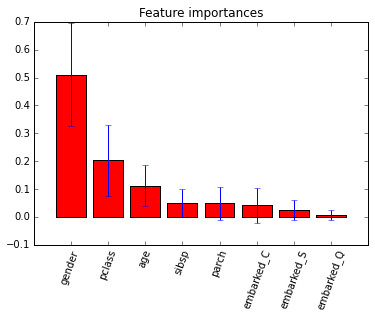

In [11]:
from sklearn.ensemble import RandomForestClassifier 

# try out different values for max_depth
for i in range(1,11):
    forest = RandomForestClassifier(n_estimators = 100, max_features='auto', max_depth=i)
    forest = forest.fit(train_data[0::,1::],train_data[0::,0])
    score = forest.score(test_data[0::,1::], test_data[0::,0])
    print "Max Depth: %s, Score: %s" % (i, score)

# use most optimal 
forest = RandomForestClassifier(n_estimators = 100, max_features='auto', max_depth=4)
forest = forest.fit(train_data[0::,1::],train_data[0::,0])
predictions = forest.predict(test_data[0::,1::])
score = forest.score(test_data[0::,1::], test_data[0::,0])
print "Score: %s" % (score)
    
# print the confusion matrix
print "Confusion Matrix:"
cm = confusion_matrix(test_data[0::,0], predictions)
print cm
print "Normalized Confusion Matrix:"
normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print normalized

# look at feature importance
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# print the feature ranking
print("Feature ranking:")
sorted_features = []
for f in range(len(indices)):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], features[indices[f]], importances[indices[f]]))
    sorted_features.append(features[indices[f]])

# plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), sorted_features, rotation=70)
plt.xlim([-1, len(indices)])
plt.show()

##Support Vector Machine
Support Vector Machines (SVM) are also good at performing classification. Here we use a linear SVM to predict. 

In [23]:
from sklearn import svm 

svm_clf = svm.SVC(kernel='linear')
svm_clf = svm_clf.fit(train_data[0::,1::],train_data[0::,0])
predictions = svm_clf.predict(test_data[0::,1::])
score = svm_clf.score(test_data[0::,1::], test_data[0::,0])
print "Score: %s" % score

# fit the training data to the survived labels 
svm_clf = svm_clf.fit(train_data[0::,1::],train_data[0::,0])
    
# print the confusion matrix
print "Confusion Matrix:"
cm = confusion_matrix(test_data[0::,0], predictions)
print cm
print "Normalized Confusion Matrix:"
normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print normalized

Score: 0.788804071247
Confusion Matrix:
[[196  28]
 [ 55 114]]
Normalized Confusion Matrix:
[[ 0.875       0.125     ]
 [ 0.32544379  0.67455621]]
